<a href="https://colab.research.google.com/github/SaketMunda/human-classifier-unsplash-dataset/blob/master/create_unsplash_dataset_human_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create own Unsplash Dataset

This notebook will be responsible for creating our own dataset of unsplash images separated into human and non-human images for training and testing purposes.

The directories will be structured into,
- **human-classifier**
  - train
    - human
    - non-human
  - test
    - human
    - non-human

We'll be using [Unsplash Lite Dataset](https://unsplash.com/data) for creating the above dataset.

In [1]:
## Importing Helper function
!wget https://github.com/SaketMunda/ml-helpers/raw/master/helper_functions.py

from helper_functions import unzip_data, walk_through_dir

--2022-12-21 06:44:00--  https://github.com/SaketMunda/ml-helpers/raw/master/helper_functions.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py [following]
--2022-12-21 06:44:00--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2022-12-21 06:44:00 (28.3 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## 1. Load Data

I've downloaded the Unsplash Lite Data zip file and saved inside my google drive.

In [6]:
# unzip the unsplash zip file
unzip_data('drive/MyDrive/Data Science/CNNExercise/unsplash-research-dataset-lite-latest.zip')

In [7]:
# inspect and the load the dataset in pandas
import pandas as pd
import glob
import numpy as np

documents = ['collections', 'photos', 'colors', 'conversions', 'keywords']
datasets = {}

for doc in documents:
  files = glob.glob(doc+".tsv*")

  subsets = []
  for filename in files:
    df = pd.read_csv(filename, sep='\t', header=0)
    subsets.append(df)
  
  datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)

## 2. Create our own Dataset of Photos

Here, the details about photos are available in `photos` object of created `dataset`. So we will create a separate csv dataset which will have information about photos and the image url to download and store them into our directory.

We'll create a function for this, which will do,
- Create a separate dataset for us, which will store photo_description, ai_description, photo_image_url, photo_id
- Download that image and store with unique photo_id for viewing purpose

First creating a separate dataset,

In [14]:
drive_path = 'drive/MyDrive/Data Science/HumanClassifier/'

# Create separate dataset for the exercise and export it
csv_dataset = datasets['photos'][['photo_id', 'photo_image_url', 'photo_description', 'ai_description']]

# export it to local drive
csv_dataset.to_csv(f'{drive_path}unsplash_photos.csv', index=False) 

In [15]:
# number of rows in unsplash_data.csv file
unsplash_df = pd.read_csv('drive/MyDrive/Data Science/HumanClassifier/unsplash_photos.csv', low_memory=False)
len(unsplash_df)

25000

### 1. Create Human Dataset

Next thing is to do that identify the photos which have humans in the dataframe to create a dataset for that we need to filter the ai description and photo description with some keywords like man, woman, girl, boy, kid, child etc...

❗**By using these list of keywords might not separate photos really good because still there are some images which doesn't contain any human**

In [16]:
# Applying the condition to unsplash_df and creating a new from it

# To use .contains in pandas you've to pass the keywords in below format
keywords = 'man|woman|girl|boy|lady|ladies|gentleman|gentlemen|crowd|people|kid|child|baby|children|human|person'

mask_photo_desc = unsplash_df['photo_description'].str.contains(keywords, case=False, na=False)
mask_ai_desc = unsplash_df['ai_description'].str.contains(keywords, case=False, na=False)

# join both the masked dataset into one
frames = [unsplash_df[mask_photo_desc], unsplash_df[mask_ai_desc]]

# here we will drop the duplicates and then rest the indexes
unsplash_human = pd.concat(objs=frames,
                           ignore_index=True).drop_duplicates().reset_index(drop=True)

In [17]:
# check if there is any duplicate
unsplash_human[unsplash_human['photo_id'].duplicated()]

,photo_id,photo_image_url,photo_description,ai_description


Export it for further experiments,

In [18]:
unsplash_human.to_csv(f'{drive_path}unsplash_human.csv', index=False)

In [19]:
# So this is the full dataset of containing humans
unsplash_human.shape

(3508, 4)

### 2. Create Non-Human Dataset

Next part is easy we need to create a dataset for non-humans, simply we will ignore the photo_ids which exist in `unsplash_human` dataset.

But fetch the number of rows equal to human dataset.

In [20]:
# take the photo_ids which should not be equal to photo_id in human dataset
unsplash_non_human = unsplash_df[~unsplash_df['photo_id'].isin(unsplash_human['photo_id'])]

# reset the index
unsplash_non_human = unsplash_non_human.reset_index(drop=True)

# taking only 3508 rows
unsplash_non_human = unsplash_non_human.iloc[:3508]

In [25]:
# export it
unsplash_non_human.to_csv(f'{drive_path}unsplash_non_human.csv', index=False)

## Download only 10% of Photos for each class (Human and Non-Human)

For now, I'll download only 10% of images for each classes, like 350 images per directory for 
- train (350)
  - human (175)
  - non-human (175)
- test (350)
  - human (175)
  - non-human (175)

In [41]:
classes = ['human', 'non-human']

# create directories if not available
import os

train_dir = f"{drive_path}photos/train"
test_dir = f"{drive_path}photos/test"

# train
if not os.path.exists(train_dir):
     os.makedirs(train_dir)

# train/human
if not os.path.exists(f"{train_dir}/human"):
     os.makedirs(f"{train_dir}/human")

# train/non-human
if not os.path.exists(f"{train_dir}/non-human"):
     os.makedirs(f"{train_dir}/non-human")

# test
if not os.path.exists(test_dir):
     os.makedirs(test_dir)

# test/human
if not os.path.exists(f"{test_dir}/human"):
     os.makedirs(f"{test_dir}/human")

# test/non-human
if not os.path.exists(f"{test_dir}/non-human"):
     os.makedirs(f"{test_dir}/non-human")

Since we are considering only 10% so dividing each into train and test set,

In [36]:
unsplash_human_train = unsplash_human.iloc[:175]
unsplash_human_test = unsplash_human.iloc[175:350]

unsplash_non_human_train = unsplash_non_human.iloc[:175]
unsplash_non_human_test = unsplash_non_human.iloc[175:350]

Alright, next thing is to download the images from photo_image_url into their respective directories.

For this, we can create a function,

In [39]:
import urllib.request

def download_images_per_class(train_dir, test_dir, train_dataset, test_dataset, class_name):
  """
  Download images from Unsplash using photo_img_url link available in the 
  dataset into the train and test directories.

  *Args:
    train_dir : Train directory
    test_dir : Test directory
    class_name : Name of class
    dataset : csv format dataset
  Return
    Nothing
  """ 

  # Train Dataset
  for index, row in train_dataset.iterrows():
    url = row.photo_image_url
    # url should be in this format
    # https://images.unsplash.com/uploads/14119492946973137ce46/f1f2ebf3
    if url.startswith('https://images.unsplash.com/'):
      filename = f"{train_dir}/{class_name}/{row.photo_id}.jpg"
      urllib.request.urlretrieve(url, filename)

  # Test Dataset
  for index, row in test_dataset.iterrows():
    url = row.photo_image_url
    if url.startswith('https://images.unsplash.com/'):
      filename = f'{test_dir}/{class_name}/{row.photo_id}.jpg'
      urllib.request.urlretrieve(url, filename)

In [42]:
# Download Human photos
download_images_per_class(train_dir=train_dir,
                          test_dir=test_dir,
                          train_dataset=unsplash_human_train,
                          test_dataset=unsplash_human_test,
                          class_name='human')
# Download non-Human photos
download_images_per_class(train_dir=train_dir,
                          test_dir=test_dir,
                          train_dataset=unsplash_non_human_train,
                          test_dataset=unsplash_non_human_test,
                          class_name='non-human')

> ❗Don't iterate with `iterrows()`, it's very slow I did with it, it take too much time, use `apply()` instead.

## 3. Visualizing Random photos

We have our own dataset with limited columns, let's visualize some photos randomly for that we'll create a function.

In [43]:
human_classifier_path = 'drive/MyDrive/Data Science/HumanClassifier/'

In [44]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_unsplash_image(df, dir, number_of_photos):
  """
  Show random image from our dataset with description
  """

  # random index
  index = random.randint(0, number_of_photos)

  # pull photo record of random index
  photo = df.iloc[index]

  # read the random photo
  img = mpimg.imread(f'{dir}/{photo.photo_id}.jpg')

  # ai description and photo description
  ai_desc = photo.ai_description
  photo_desc = photo.photo_description

  # plot the image with description
  plt.title(f"Photo desc = {photo_desc}, AI desc = {ai_desc}")
  plt.imshow(img)
  plt.axis(False)

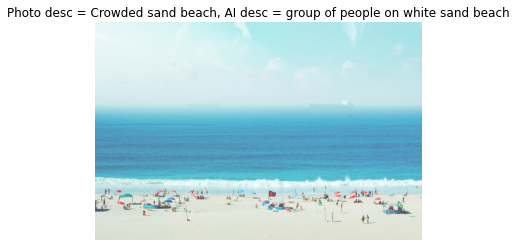

In [53]:
# view random train data of human
view_random_unsplash_image(unsplash_human_train, train_dir+"/human", unsplash_human_train.shape[0])

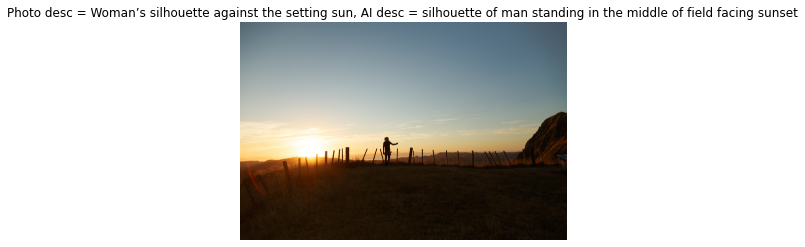

In [57]:
# view random test data of human
view_random_unsplash_image(unsplash_human_test, test_dir+"/human", unsplash_human_test.shape[0])

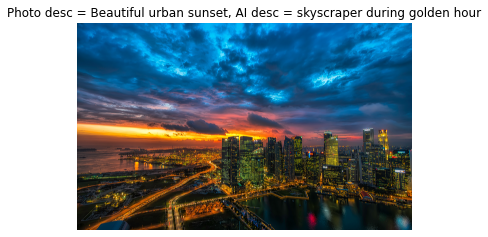

In [60]:
# view random train data of non-human
view_random_unsplash_image(unsplash_non_human_train, train_dir+"/non-human", unsplash_non_human_train.shape[0])

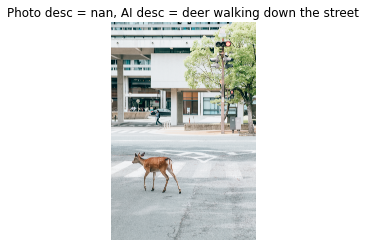

In [62]:
# view random test data of non-human
view_random_unsplash_image(unsplash_non_human_test, test_dir+"/non-human", unsplash_non_human_test.shape[0])

We're done with creating a dataset for further experiment.

**Note : Human Dataset is still not perfect, we can try other approaches to distinguish the images**